In [48]:
# CPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

import mlflow
import dagshub

import json
import gc
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow: {tf.__version__}")
print(f"Optuna: {optuna.__version__}")

TensorFlow: 2.20.0
Optuna: 4.6.0


In [50]:
# Verificar GPU
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs disponibles: {len(gpus)}")

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU configurada correctamente: {gpus[0].name}")
    except RuntimeError as e:
        print(f"Error al configurar GPU: {e}")
else:
    print("No se detectó GPU, usando CPU")

GPUs disponibles: 0
No se detectó GPU, usando CPU


In [51]:
# DagsHub
dagshub.init(repo_owner='404brainnotfound-ai', repo_name='Tarea_6', mlflow=True)
mlflow.set_experiment("Plant_Pathology_2020")

print(f"URI de seguimiento MLflow: {mlflow.get_tracking_uri()}")

Initialized MLflow to track repo "404brainnotfound-ai/Tarea_6"

Repository 404brainnotfound-ai/Tarea_6 initialized!

URI de seguimiento MLflow: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow


In [52]:
# Rutas
DIRECTORIO_BASE = "plant-pathology-2020-fgvc7"
DIRECTORIO_IMAGENES = os.path.join(DIRECTORIO_BASE, "images")
ARCHIVO_TRAIN = os.path.join(DIRECTORIO_BASE, "train.csv")
ARCHIVO_TEST = os.path.join(DIRECTORIO_BASE, "test.csv")

# Parámetros de entrenamiento
TAMAÑO_IMAGEN = (160, 160)
TAMAÑO_LOTE = 8
SEMILLA = 42
NUM_CLASES = 4

# Configurar semillas para reproducibilidad
tf.random.set_seed(SEMILLA)
np.random.seed(SEMILLA)

print("Configuración:")
print(f"  Tamaño de imagen: {TAMAÑO_IMAGEN}")
print(f"  Tamaño de lote: {TAMAÑO_LOTE}")
print(f"  Número de clases: {NUM_CLASES}")

Configuración:
  Tamaño de imagen: (160, 160)
  Tamaño de lote: 8
  Número de clases: 4


In [53]:
# Cargar datos
df = pd.read_csv(ARCHIVO_TRAIN)
df['image_id'] = df['image_id'] + '.jpg'
df = df.drop_duplicates(subset='image_id').reset_index(drop=True)

print(f"Total de imágenes: {len(df)}")
print("\nPrimeras filas:")
print(df.head())

Total de imágenes: 1821

Primeras filas:
      image_id  healthy  multiple_diseases  rust  scab
0  Train_0.jpg        0                  0     0     1
1  Train_1.jpg        0                  1     0     0
2  Train_2.jpg        1                  0     0     0
3  Train_3.jpg        0                  0     1     0
4  Train_4.jpg        1                  0     0     0


Distribución de clases:
  healthy             :  516 (28.34%)
  multiple_diseases   :   91 ( 5.00%)
  rust                :  622 (34.16%)
  scab                :  592 (32.51%)


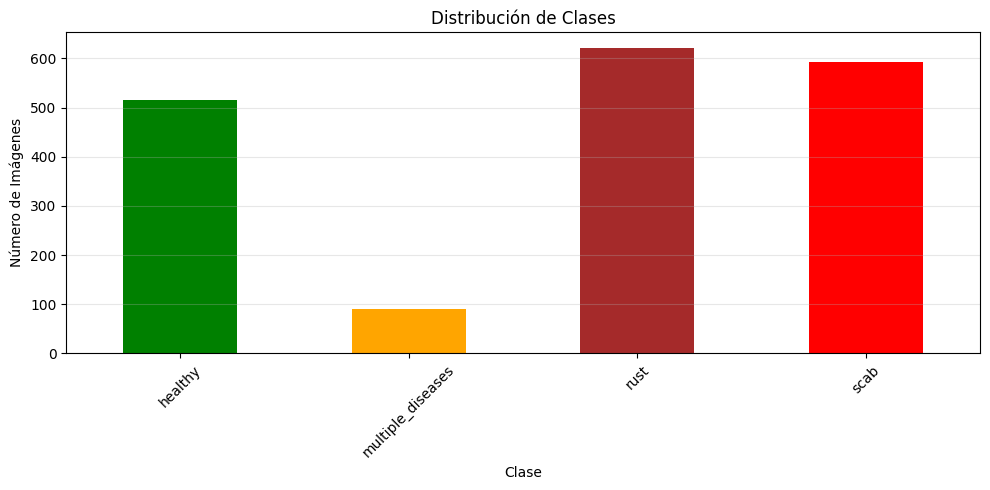

In [54]:
# Analizar distribución de clases
etiquetas = ['healthy', 'multiple_diseases', 'rust', 'scab']
conteo_clases = df[etiquetas].sum()

print("Distribución de clases:")
for etiqueta in etiquetas:
    conteo = conteo_clases[etiqueta]
    porcentaje = (conteo / len(df)) * 100
    print(f"  {etiqueta:20s}: {conteo:4d} ({porcentaje:5.2f}%)")

# Visualizar
plt.figure(figsize=(10, 5))
conteo_clases.plot(kind='bar', color=['green', 'orange', 'brown', 'red'])
plt.title('Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Número de Imágenes')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [55]:
# Preparar etiquetas
y = df[etiquetas].values.astype(np.float32)
df['indice_clase'] = np.argmax(y, axis=1)

# División: 70% train+val, 30% test
df_train_val, df_test, y_train_val, y_test = train_test_split(
    df, y,
    test_size=0.30,
    random_state=SEMILLA,
    stratify=df['indice_clase'],
    shuffle=True)

# División de train_val: 80% train, 20% val
df_train, df_val, y_train, y_val = train_test_split(
    df_train_val, y_train_val,
    test_size=0.20,
    random_state=SEMILLA,
    stratify=df_train_val['indice_clase'],
    shuffle=True)

print("División de datos:")
print(f"  Train:      {len(df_train):4d} ({len(df_train)/len(df)*100:5.1f}%)")
print(f"  Validation: {len(df_val):4d} ({len(df_val)/len(df)*100:5.1f}%)")
print(f"  Test:       {len(df_test):4d} ({len(df_test)/len(df)*100:5.1f}%)")
print(f"  Total:      {len(df):4d}")

División de datos:
  Train:      1019 ( 56.0%)
  Validation:  255 ( 14.0%)
  Test:        547 ( 30.0%)
  Total:      1821


In [56]:
# Calcular pesos de clase para balanceo
pesos_clase = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train['indice_clase']),
    y=df_train['indice_clase'])
    
diccionario_pesos_clase = {i: peso for i, peso in enumerate(pesos_clase)}

print("\nPesos de clase:")
for i, (etiqueta, peso) in enumerate(zip(etiquetas, pesos_clase)):
    print(f"  {etiqueta:20s}: {peso:.3f}")


Pesos de clase:
  healthy             : 0.881
  multiple_diseases   : 4.995
  rust                : 0.732
  scab                : 0.770


# Pipeline de Datos

In [57]:
def obtener_funcion_preprocesamiento(arquitectura):
    """
    Retorna la función de preprocesamiento según la arquitectura
    """
    if arquitectura == "MobileNetV2":
        return tf.keras.applications.mobilenet_v2.preprocess_input
    elif arquitectura == "EfficientNetB0":
        return tf.keras.applications.efficientnet.preprocess_input
    else:
        return None

def crear_capas_augmentacion(trial=None):
    """
    Crea capas de data augmentation
    Si se proporciona trial de Optuna, optimiza los parámetros
    """
    if trial is not None:
        rotacion = trial.suggest_float("rotacion", 0.05, 0.15)
        zoom = trial.suggest_float("zoom", 0.05, 0.15)
        contraste = trial.suggest_float("contraste", 0.1, 0.3)
    else:
        rotacion = 0.1
        zoom = 0.1
        contraste = 0.2
    
    return keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(rotacion),
        layers.RandomZoom(zoom),
        layers.RandomContrast(contraste),
        layers.RandomBrightness(0.1),
        layers.RandomTranslation(0.1, 0.1),
    ], name="augmentacion")

def crear_dataset(df_split, etiquetas_split, es_entrenamiento=True):
    """
    Crea un tf.data.Dataset optimizado
    """
    rutas_archivos = [os.path.join(DIRECTORIO_IMAGENES, img_id) for img_id in df_split['image_id']]
    
    dataset = tf.data.Dataset.from_tensor_slices((rutas_archivos, etiquetas_split))
    
    def cargar_y_preprocesar(ruta, etiqueta):
        img = tf.io.read_file(ruta)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, TAMAÑO_IMAGEN)
        img = tf.cast(img, tf.float32)
        return img, etiqueta
    
    dataset = dataset.map(cargar_y_preprocesar, num_parallel_calls=tf.data.AUTOTUNE)
    
    if es_entrenamiento:
        dataset = dataset.shuffle(buffer_size=1000, seed=SEMILLA, reshuffle_each_iteration=True)
    
    dataset = dataset.batch(TAMAÑO_LOTE).prefetch(tf.data.AUTOTUNE)
    return dataset

print("Pipeline de datos definido")

Pipeline de datos definido


In [58]:
def crear_modelo(trial, num_clases=4, tamaño_img=TAMAÑO_IMAGEN):  # Usar TAMAÑO_IMAGEN global
    """
    Crea un modelo con hiperparámetros optimizados por Optuna
    """
    tf.keras.backend.clear_session()
    gc.collect()
    
    # Seleccionar arquitectura
    arquitectura = trial.suggest_categorical("arquitectura", ["MobileNetV2", "EfficientNetB0"])
    
    # Crear modelo base
    if arquitectura == "MobileNetV2":
        modelo_base = MobileNetV2(
            include_top=False,
            weights="imagenet",
            input_shape=tamaño_img + (3,))
    else:
        modelo_base = EfficientNetB0(
            include_top=False,
            weights="imagenet",
            input_shape=tamaño_img + (3,))
    
    # Congelar capas
    ratio_congelamiento = trial.suggest_float("ratio_congelamiento", 0.5, 0.9)
    num_capas = len(modelo_base.layers)
    num_congelar = int(num_capas * ratio_congelamiento)
    
    for capa in modelo_base.layers[:num_congelar]:
        capa.trainable = False
    
    # Hiperparámetros del clasificador
    tipo_pooling = trial.suggest_categorical("pooling", ["avg", "max"])
    dropout1 = trial.suggest_float("dropout1", 0.2, 0.5)
    dropout2 = trial.suggest_float("dropout2", 0.1, 0.4)
    unidades = trial.suggest_categorical("unidades", [128, 256, 512])
    usar_batchnorm = trial.suggest_categorical("usar_batchnorm", [True, False])
    
    # Construir modelo
    entradas = layers.Input(shape=tamaño_img + (3,))
    
    # Data augmentation
    x = crear_capas_augmentacion(trial)(entradas)
    
    # Preprocesamiento específico
    if arquitectura == "MobileNetV2":
        x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    else:
        x = tf.keras.applications.efficientnet.preprocess_input(x)
    
    # Modelo base
    x = modelo_base(x, training=False)
    
    # Pooling
    if tipo_pooling == "avg":
        x = layers.GlobalAveragePooling2D()(x)
    else:
        x = layers.GlobalMaxPooling2D()(x)
    
    # Clasificador
    if usar_batchnorm:
        x = layers.BatchNormalization()(x)
    
    x = layers.Dropout(dropout1)(x)
    x = layers.Dense(unidades, activation="relu")(x)
    
    if usar_batchnorm:
        x = layers.BatchNormalization()(x)
    
    x = layers.Dropout(dropout2)(x)
    salidas = layers.Dense(num_clases, activation="softmax")(x)
    
    modelo = keras.Model(entradas, salidas)
    
    # Compilar
    tasa_aprendizaje = trial.suggest_float("tasa_aprendizaje", 1e-4, 1e-3, log=True)
    
    modelo.compile(
        optimizer=keras.optimizers.Adam(learning_rate=tasa_aprendizaje),
        loss="categorical_crossentropy",
        metrics=["accuracy"])
    
    return modelo, arquitectura

print("Función de creación de modelos definida")

Función de creación de modelos definida


In [59]:
def objetivo_busqueda(trial):
    """
    Función objetivo para Optuna - Búsqueda principal
    """
    with mlflow.start_run(nested=True, run_name=f"Trial_{trial.number}"):
        
        # Crear modelo
        modelo, arquitectura = crear_modelo(trial, num_clases=NUM_CLASES)
        
        # Crear datasets
        ds_train = crear_dataset(df_train, y_train, es_entrenamiento=True)
        ds_val = crear_dataset(df_val, y_val, es_entrenamiento=False)
        
        # Registrar parámetros
        mlflow.log_params(trial.params)
        mlflow.log_param("arquitectura", arquitectura)
        
        # Callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_accuracy',
                mode='max',
                patience=5,
                restore_best_weights=True,
                verbose=0),
            ReduceLROnPlateau(
                monitor='val_loss',
                mode='min',
                factor=0.5,
                patience=3,
                verbose=0,
                min_lr=1e-7)]
        
        # Entrenar
        history = modelo.fit(
            ds_train,
            validation_data=ds_val,
            epochs=25,
            callbacks=callbacks,
            class_weight=diccionario_pesos_clase,
            verbose=0)
        
        # Obtener métricas
        mejor_val_acc = max(history.history['val_accuracy'])
        mejor_val_loss = min(history.history['val_loss'])
        
        mlflow.log_metric("mejor_val_accuracy", mejor_val_acc)
        mlflow.log_metric("mejor_val_loss", mejor_val_loss)
        
        # Limpiar memoria
        del modelo, ds_train, ds_val
        tf.keras.backend.clear_session()
        gc.collect()
        
        print(f"Trial {trial.number:3d} | {arquitectura:15s} | Val Acc: {mejor_val_acc:.4f}")
        
        return mejor_val_acc

print("Función objetivo de búsqueda definida")

Función objetivo de búsqueda definida


In [60]:
# Configurar y ejecutar búsqueda
NUM_TRIALS_BUSQUEDA = 20

print(f"Iniciando búsqueda con Optuna: {NUM_TRIALS_BUSQUEDA} trials")
print("Arquitecturas: MobileNetV2, EfficientNetB0")

Iniciando búsqueda con Optuna: 20 trials
Arquitecturas: MobileNetV2, EfficientNetB0


In [61]:
# Crear estudio de Optuna con almacenamiento persistente
estudio_busqueda = optuna.create_study(
    direction="maximize",
    study_name="Plant_Pathology_Busqueda",
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=10),
    sampler=optuna.samplers.TPESampler(seed=SEMILLA),
    storage="sqlite:///optuna_study.db",
    load_if_exists=True)

print("Estudio de Optuna creado")

[I 2025-11-27 18:42:41,410] A new study created in RDB with name: Plant_Pathology_Busqueda


Estudio de Optuna creado


In [62]:
# Ejecutar optimización
with mlflow.start_run(run_name="Busqueda_Principal"):
    
    TAMAÑO_LOTE_ORIGINAL = TAMAÑO_LOTE
    TAMAÑO_LOTE = 8  
    
    estudio_busqueda.optimize(objetivo_busqueda, n_trials=NUM_TRIALS_BUSQUEDA, show_progress_bar=True)
    
    # Restaurar batch size
    TAMAÑO_LOTE = TAMAÑO_LOTE_ORIGINAL
    
    # Guardar mejores parámetros
    mejores_params = estudio_busqueda.best_trial.params
    mejor_valor = estudio_busqueda.best_trial.value
    
    mlflow.log_params(mejores_params)
    mlflow.log_metric("mejor_val_accuracy", mejor_valor)
    mlflow.log_param("num_trials", NUM_TRIALS_BUSQUEDA)
    
    print(f"\nMejor Trial: {estudio_busqueda.best_trial.number}")
    print(f"Mejor Val Accuracy: {mejor_valor:.4f}")
    print(f"\nMejores hiperparametros:")
    for clave, valor in mejores_params.items():
        print(f"  {clave}: {valor}")

  0%|          | 0/20 [00:00<?, ?it/s]

Trial   0 | EfficientNetB0  | Val Acc: 0.7922
🏃 View run Trial_0 at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/d941e349aa2942a9988f01b5ba056ab8
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0


Best trial: 0. Best value: 0.792157:   5%|▌         | 1/20 [05:56<1:52:46, 356.14s/it]

[I 2025-11-27 18:48:37,800] Trial 0 finished with value: 0.7921568751335144 and parameters: {'arquitectura': 'EfficientNetB0', 'ratio_congelamiento': 0.7927975767245621, 'pooling': 'avg', 'dropout1': 0.24679835610086082, 'dropout2': 0.11742508365045984, 'unidades': 128, 'usar_batchnorm': False, 'rotacion': 0.13324426408004217, 'zoom': 0.07123391106782762, 'contraste': 0.1363649934414201, 'tasa_aprendizaje': 0.00015254729458052615}. Best is trial 0 with value: 0.7921568751335144.
Trial   1 | EfficientNetB0  | Val Acc: 0.8196
🏃 View run Trial_1 at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/4efb5326395045729b1553463ead0de7
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0


Best trial: 1. Best value: 0.819608:  10%|█         | 2/20 [16:38<2:37:18, 524.39s/it]

[I 2025-11-27 18:59:19,958] Trial 1 finished with value: 0.8196078538894653 and parameters: {'arquitectura': 'EfficientNetB0', 'ratio_congelamiento': 0.6727780074568463, 'pooling': 'max', 'dropout1': 0.24184815819561256, 'dropout2': 0.18764339456056545, 'unidades': 512, 'usar_batchnorm': False, 'rotacion': 0.10924145688620424, 'zoom': 0.054645041271999775, 'contraste': 0.22150897038028766, 'tasa_aprendizaje': 0.00014808945119975197}. Best is trial 1 with value: 0.8196078538894653.
Trial   2 | EfficientNetB0  | Val Acc: 0.8196
🏃 View run Trial_2 at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/19f545ade0da40f49bfd2e57feca57ed
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0


Best trial: 1. Best value: 0.819608:  15%|█▌        | 3/20 [21:59<2:02:15, 431.49s/it]

[I 2025-11-27 19:04:40,912] Trial 2 finished with value: 0.8196078538894653 and parameters: {'arquitectura': 'EfficientNetB0', 'ratio_congelamiento': 0.8862528132298237, 'pooling': 'avg', 'dropout1': 0.22930163420191518, 'dropout2': 0.3052699079536471, 'unidades': 512, 'usar_batchnorm': False, 'rotacion': 0.0758779981600017, 'zoom': 0.11625222843539819, 'contraste': 0.1623422152178822, 'tasa_aprendizaje': 0.000331182988807238}. Best is trial 1 with value: 0.8196078538894653.
Trial   3 | MobileNetV2     | Val Acc: 0.8235
🏃 View run Trial_3 at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/d23705922edc4ba6be2e587235461c18
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0


Best trial: 3. Best value: 0.823529:  20%|██        | 4/20 [28:11<1:48:47, 407.94s/it]

[I 2025-11-27 19:10:52,739] Trial 3 finished with value: 0.8235294222831726 and parameters: {'arquitectura': 'MobileNetV2', 'ratio_congelamiento': 0.8878338511058235, 'pooling': 'max', 'dropout1': 0.46844820512829466, 'dropout2': 0.2793699936433256, 'unidades': 128, 'usar_batchnorm': False, 'rotacion': 0.0888677289689482, 'zoom': 0.0771349031773896, 'contraste': 0.26574750183038587, 'tasa_aprendizaje': 0.00022738055735631828}. Best is trial 3 with value: 0.8235294222831726.
Trial   4 | EfficientNetB0  | Val Acc: 0.8314


Best trial: 4. Best value: 0.831373:  25%|██▌       | 5/20 [34:02<1:36:55, 387.69s/it]

🏃 View run Trial_4 at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/bc72429278e74efcb992a5d469a91c89
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0
[I 2025-11-27 19:16:44,527] Trial 4 finished with value: 0.8313725590705872 and parameters: {'arquitectura': 'EfficientNetB0', 'ratio_congelamiento': 0.5563696899899051, 'pooling': 'avg', 'dropout1': 0.4960660809801552, 'dropout2': 0.33167343078899725, 'unidades': 512, 'usar_batchnorm': False, 'rotacion': 0.12712703466859457, 'zoom': 0.05740446517340904, 'contraste': 0.17169314570885452, 'tasa_aprendizaje': 0.00013057771348997234}. Best is trial 4 with value: 0.8313725590705872.
Trial   5 | MobileNetV2     | Val Acc: 0.8824
🏃 View run Trial_5 at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/51b64fe50c1f46eba47c86cec7e8a350
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0


Best trial: 5. Best value: 0.882353:  30%|███       | 6/20 [41:56<1:37:16, 416.86s/it]

[I 2025-11-27 19:24:38,015] Trial 5 finished with value: 0.8823529481887817 and parameters: {'arquitectura': 'MobileNetV2', 'ratio_congelamiento': 0.6323592099410597, 'pooling': 'max', 'dropout1': 0.2975549966080241, 'dropout2': 0.3188818535014193, 'unidades': 256, 'usar_batchnorm': False, 'rotacion': 0.12607850486168976, 'zoom': 0.10612771975694962, 'contraste': 0.25419343599091215, 'tasa_aprendizaje': 0.0003117422003004634}. Best is trial 5 with value: 0.8823529481887817.
Trial   6 | MobileNetV2     | Val Acc: 0.8471
🏃 View run Trial_6 at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/44f01102efd14ee68ca020bf5d86d4b1
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0


Best trial: 5. Best value: 0.882353:  35%|███▌      | 7/20 [48:31<1:28:45, 409.64s/it]

[I 2025-11-27 19:31:12,791] Trial 6 finished with value: 0.8470588326454163 and parameters: {'arquitectura': 'MobileNetV2', 'ratio_congelamiento': 0.510167650697638, 'pooling': 'avg', 'dropout1': 0.39092312337913415, 'dropout2': 0.19430679432289802, 'unidades': 256, 'usar_batchnorm': False, 'rotacion': 0.07287981654916224, 'zoom': 0.0576979909828793, 'contraste': 0.15795029058275362, 'tasa_aprendizaje': 0.00014495102383254693}. Best is trial 5 with value: 0.8823529481887817.
Trial   7 | MobileNetV2     | Val Acc: 0.6627
🏃 View run Trial_7 at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/a55a0e9af6bd4ef5836d422905c4a293
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0


Best trial: 5. Best value: 0.882353:  40%|████      | 8/20 [53:36<1:15:15, 376.31s/it]

[I 2025-11-27 19:36:17,721] Trial 7 finished with value: 0.6627451181411743 and parameters: {'arquitectura': 'MobileNetV2', 'ratio_congelamiento': 0.7533615026041693, 'pooling': 'avg', 'dropout1': 0.25597101766581076, 'dropout2': 0.3677676995469934, 'unidades': 512, 'usar_batchnorm': True, 'rotacion': 0.07279351625419417, 'zoom': 0.09271077886262563, 'contraste': 0.2636029531844986, 'tasa_aprendizaje': 0.0007256556536786186}. Best is trial 5 with value: 0.8823529481887817.
Trial   8 | EfficientNetB0  | Val Acc: 0.7922
🏃 View run Trial_8 at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/576649d326f145acbaaaa9c91204dc8e
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0


Best trial: 5. Best value: 0.882353:  45%|████▌     | 9/20 [58:42<1:04:59, 354.51s/it]

[I 2025-11-27 19:41:24,299] Trial 8 finished with value: 0.7921568751335144 and parameters: {'arquitectura': 'EfficientNetB0', 'ratio_congelamiento': 0.6669644012595116, 'pooling': 'avg', 'dropout1': 0.3012845514210884, 'dropout2': 0.38287291117375577, 'unidades': 512, 'usar_batchnorm': False, 'rotacion': 0.14624472949421113, 'zoom': 0.07517822958253642, 'contraste': 0.1994497011784771, 'tasa_aprendizaje': 0.00019993015828338186}. Best is trial 5 with value: 0.8823529481887817.
Trial   9 | MobileNetV2     | Val Acc: 0.5608
🏃 View run Trial_9 at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/c4408222883c4fe28e3709b0900b4234
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0


Best trial: 5. Best value: 0.882353:  50%|█████     | 10/20 [1:01:14<48:39, 291.95s/it] 

[I 2025-11-27 19:43:56,180] Trial 9 finished with value: 0.5607843399047852 and parameters: {'arquitectura': 'MobileNetV2', 'ratio_congelamiento': 0.7438257335919587, 'pooling': 'avg', 'dropout1': 0.2835939392709834, 'dropout2': 0.3724797657899962, 'unidades': 512, 'usar_batchnorm': True, 'rotacion': 0.11721355474058785, 'zoom': 0.12616196153287174, 'contraste': 0.14752750879847992, 'tasa_aprendizaje': 0.0005348307249011097}. Best is trial 5 with value: 0.8823529481887817.
Trial  10 | MobileNetV2     | Val Acc: 0.7020
🏃 View run Trial_10 at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/05c38bc21362415897a7576718dc4525
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0


Best trial: 5. Best value: 0.882353:  55%|█████▌    | 11/20 [1:06:23<44:34, 297.19s/it]

[I 2025-11-27 19:49:05,232] Trial 10 finished with value: 0.7019608020782471 and parameters: {'arquitectura': 'MobileNetV2', 'ratio_congelamiento': 0.6035845655308416, 'pooling': 'max', 'dropout1': 0.35792969143845893, 'dropout2': 0.2361049458170283, 'unidades': 256, 'usar_batchnorm': True, 'rotacion': 0.09272701478873474, 'zoom': 0.14469618763901493, 'contraste': 0.29847253309206745, 'tasa_aprendizaje': 0.0003894706089427724}. Best is trial 5 with value: 0.8823529481887817.
Trial  11 | MobileNetV2     | Val Acc: 0.8118
🏃 View run Trial_11 at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/a1db374553754728a016e828a19f1fed
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0


Best trial: 5. Best value: 0.882353:  60%|██████    | 12/20 [1:18:44<57:36, 432.10s/it]

[I 2025-11-27 20:01:25,895] Trial 11 finished with value: 0.8117647171020508 and parameters: {'arquitectura': 'MobileNetV2', 'ratio_congelamiento': 0.5170324364998508, 'pooling': 'max', 'dropout1': 0.3986703598670434, 'dropout2': 0.2095438243585528, 'unidades': 256, 'usar_batchnorm': False, 'rotacion': 0.051994118672829416, 'zoom': 0.10181591656643187, 'contraste': 0.21839268945693724, 'tasa_aprendizaje': 0.00010314224429411388}. Best is trial 5 with value: 0.8823529481887817.
Trial  12 | MobileNetV2     | Val Acc: 0.8431
🏃 View run Trial_12 at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/28046b3a302a467abd355fe916e23b9a
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0


Best trial: 5. Best value: 0.882353:  65%|██████▌   | 13/20 [1:25:08<48:44, 417.73s/it]

[I 2025-11-27 20:07:50,571] Trial 12 finished with value: 0.843137264251709 and parameters: {'arquitectura': 'MobileNetV2', 'ratio_congelamiento': 0.6054618949178086, 'pooling': 'max', 'dropout1': 0.41109999587462015, 'dropout2': 0.1449466602303131, 'unidades': 256, 'usar_batchnorm': False, 'rotacion': 0.05307567823305922, 'zoom': 0.09901071260073743, 'contraste': 0.10159309665752084, 'tasa_aprendizaje': 0.0002443876283052332}. Best is trial 5 with value: 0.8823529481887817.
Trial  13 | MobileNetV2     | Val Acc: 0.8196
🏃 View run Trial_13 at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/84867a3e77d7422aa1169a69b6017ef1
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0


Best trial: 5. Best value: 0.882353:  70%|███████   | 14/20 [1:32:40<42:48, 428.06s/it]

[I 2025-11-27 20:15:22,516] Trial 13 finished with value: 0.8196078538894653 and parameters: {'arquitectura': 'MobileNetV2', 'ratio_congelamiento': 0.5971463291368737, 'pooling': 'max', 'dropout1': 0.3349524804293248, 'dropout2': 0.2632969700721353, 'unidades': 256, 'usar_batchnorm': False, 'rotacion': 0.07531209901564508, 'zoom': 0.12104696631860315, 'contraste': 0.24329372322939957, 'tasa_aprendizaje': 0.0004888277171563409}. Best is trial 5 with value: 0.8823529481887817.
Trial  14 | MobileNetV2     | Val Acc: 0.8275
🏃 View run Trial_14 at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/2314b6b5571e4da983a9f2983f92a67d
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0


Best trial: 5. Best value: 0.882353:  75%|███████▌  | 15/20 [1:41:42<38:32, 462.42s/it]

[I 2025-11-27 20:24:24,563] Trial 14 finished with value: 0.8274509906768799 and parameters: {'arquitectura': 'MobileNetV2', 'ratio_congelamiento': 0.5068648171008258, 'pooling': 'avg', 'dropout1': 0.3874512487280244, 'dropout2': 0.17935417994229705, 'unidades': 256, 'usar_batchnorm': True, 'rotacion': 0.10597609442122047, 'zoom': 0.10953568034510394, 'contraste': 0.12112706770020867, 'tasa_aprendizaje': 0.0008565490056259828}. Best is trial 5 with value: 0.8823529481887817.
Trial  15 | MobileNetV2     | Val Acc: 0.5843
🏃 View run Trial_15 at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/d8b0a1029827459ba6916250c1650357
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0


Best trial: 5. Best value: 0.882353:  80%|████████  | 16/20 [1:44:34<24:59, 374.89s/it]

[I 2025-11-27 20:27:16,173] Trial 15 finished with value: 0.5843137502670288 and parameters: {'arquitectura': 'MobileNetV2', 'ratio_congelamiento': 0.6447503836849965, 'pooling': 'max', 'dropout1': 0.3311985182395312, 'dropout2': 0.3252991708037578, 'unidades': 256, 'usar_batchnorm': False, 'rotacion': 0.14002148367830047, 'zoom': 0.08867022156666779, 'contraste': 0.18724123420740701, 'tasa_aprendizaje': 0.0002784994259025065}. Best is trial 5 with value: 0.8823529481887817.
Trial  16 | MobileNetV2     | Val Acc: 0.6863
🏃 View run Trial_16 at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/d494ba550d3744f88b140f1353bb6927
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0


Best trial: 5. Best value: 0.882353:  85%|████████▌ | 17/20 [1:47:46<15:59, 319.87s/it]

[I 2025-11-27 20:30:28,086] Trial 16 finished with value: 0.686274528503418 and parameters: {'arquitectura': 'MobileNetV2', 'ratio_congelamiento': 0.5560608027188066, 'pooling': 'max', 'dropout1': 0.44419811167334955, 'dropout2': 0.2335425366416529, 'unidades': 256, 'usar_batchnorm': False, 'rotacion': 0.1193686291586791, 'zoom': 0.1309672869016001, 'contraste': 0.28225515747841035, 'tasa_aprendizaje': 0.00017569141230210105}. Best is trial 5 with value: 0.8823529481887817.
Trial  17 | MobileNetV2     | Val Acc: 0.7373
🏃 View run Trial_17 at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/aa971e199a1046098db7eb88fa914c12
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0


Best trial: 5. Best value: 0.882353:  90%|█████████ | 18/20 [1:52:16<10:09, 304.78s/it]

[I 2025-11-27 20:34:57,735] Trial 17 finished with value: 0.7372549176216125 and parameters: {'arquitectura': 'MobileNetV2', 'ratio_congelamiento': 0.7255898796085731, 'pooling': 'avg', 'dropout1': 0.29608759503270715, 'dropout2': 0.2994907190478136, 'unidades': 256, 'usar_batchnorm': False, 'rotacion': 0.06610960438681393, 'zoom': 0.13950834754968622, 'contraste': 0.22774029658459535, 'tasa_aprendizaje': 0.00010618058237130765}. Best is trial 5 with value: 0.8823529481887817.
Trial  18 | MobileNetV2     | Val Acc: 0.7804
🏃 View run Trial_18 at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/fce94ae28239482bb79380f52c6681ed
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0


Best trial: 5. Best value: 0.882353:  95%|█████████▌| 19/20 [1:57:53<05:14, 314.50s/it]

[I 2025-11-27 20:40:34,870] Trial 18 finished with value: 0.7803921699523926 and parameters: {'arquitectura': 'MobileNetV2', 'ratio_congelamiento': 0.5540448026639813, 'pooling': 'avg', 'dropout1': 0.20162762276566537, 'dropout2': 0.15601722587052755, 'unidades': 128, 'usar_batchnorm': True, 'rotacion': 0.09090010710703236, 'zoom': 0.06387699394305989, 'contraste': 0.17639401320939518, 'tasa_aprendizaje': 0.000384264864422341}. Best is trial 5 with value: 0.8823529481887817.
Trial  19 | MobileNetV2     | Val Acc: 0.5843


Best trial: 5. Best value: 0.882353: 100%|██████████| 20/20 [2:04:37<00:00, 373.90s/it]

🏃 View run Trial_19 at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/b3d8930d0d7b4f38b2b67a9c5a220f38
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0
[I 2025-11-27 20:47:19,622] Trial 19 finished with value: 0.5843137502670288 and parameters: {'arquitectura': 'MobileNetV2', 'ratio_congelamiento': 0.7927667771131522, 'pooling': 'max', 'dropout1': 0.3600371423819496, 'dropout2': 0.10034802058646912, 'unidades': 256, 'usar_batchnorm': False, 'rotacion': 0.10470626071341155, 'zoom': 0.08323676453747379, 'contraste': 0.24695560586438436, 'tasa_aprendizaje': 0.0006473101482047726}. Best is trial 5 with value: 0.8823529481887817.



Mejor Trial: 5
Mejor Val Accuracy: 0.8824

Mejores hiperparametros:
  arquitectura: MobileNetV2
  ratio_congelamiento: 0.6323592099410597
  pooling: max
  dropout1: 0.2975549966080241
  dropout2: 0.3188818535014193
  unidades: 256
  usar_batchnorm: False
  rotacion: 0.12607850486168976
  zoom: 0.10612771975694962
  contraste: 0.25419343599091215
  tasa_aprendizaje: 0.0003117422003004634
🏃 View run Busqueda_Principal at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/8ffb16fd592c4edf9eda8adacb2c6e3f
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0


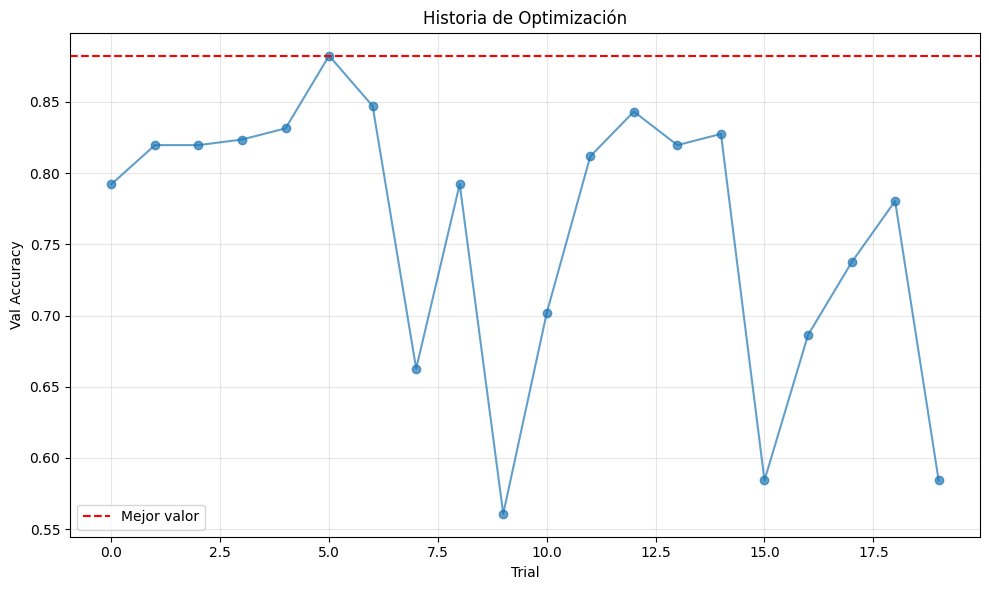

In [63]:
# Historia de optimización
import matplotlib.pyplot as plt

trials_df = estudio_busqueda.trials_dataframe()

plt.figure(figsize=(10, 6))
plt.plot(trials_df['number'], trials_df['value'], marker='o', linestyle='-', alpha=0.7)
plt.axhline(y=trials_df['value'].max(), color='r', linestyle='--', label='Mejor valor')
plt.xlabel('Trial')
plt.ylabel('Val Accuracy')
plt.title('Historia de Optimización')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

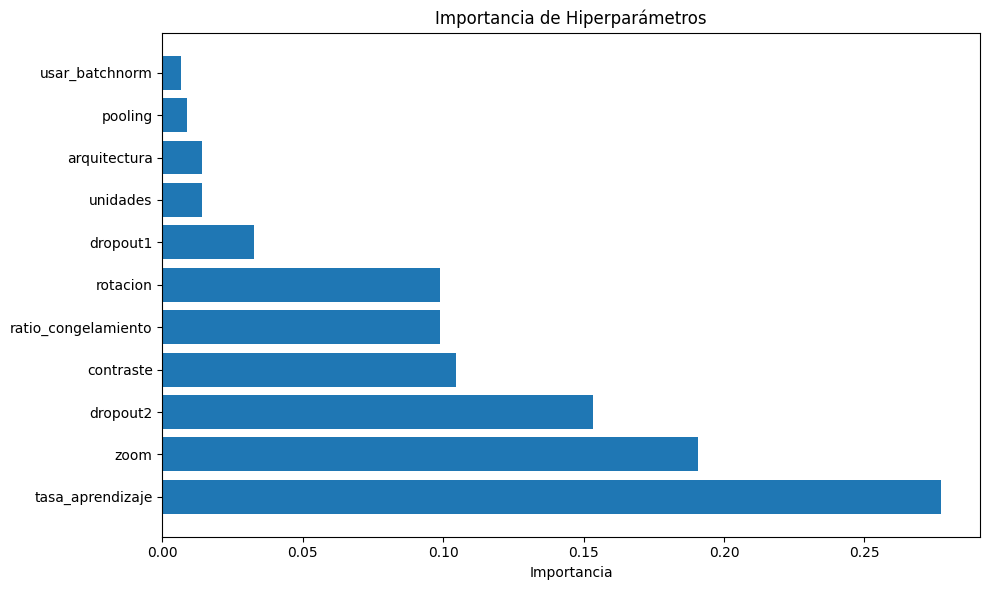

In [65]:
# Importancia de hiperparámetros

importance = optuna.importance.get_param_importances(estudio_busqueda)

plt.figure(figsize=(10, 6))
params = list(importance.keys())
values = list(importance.values())
plt.barh(params, values)
plt.xlabel('Importancia')
plt.title('Importancia de Hiperparámetros')
plt.tight_layout()
plt.show()

In [67]:
# Guardar mejores parámetros
with open('mejores_params_busqueda.json', 'w') as f:
    json.dump(mejores_params, f, indent=4)

print("Mejores parámetros guardados: mejores_params_busqueda.json")

Mejores parámetros guardados: mejores_params_busqueda.json


In [68]:
# Guardar resultados de todos los trials

df_trials = estudio_busqueda.trials_dataframe()
df_trials.to_csv("resultados_trials_busqueda.csv", index=False)

print("Resultados guardados: resultados_trials_busqueda.csv")
print("\nTop 5 mejores trials:")
print(df_trials.nlargest(5, 'value')[['number', 'value', 'params_arquitectura', 
                                       'params_tasa_aprendizaje', 'params_unidades']].round(4))

Resultados guardados: resultados_trials_busqueda.csv

Top 5 mejores trials:
    number   value params_arquitectura  params_tasa_aprendizaje  \
5        5  0.8824         MobileNetV2                   0.0003   
6        6  0.8471         MobileNetV2                   0.0001   
12      12  0.8431         MobileNetV2                   0.0002   
4        4  0.8314      EfficientNetB0                   0.0001   
14      14  0.8275         MobileNetV2                   0.0009   

    params_unidades  
5               256  
6               256  
12              256  
4               512  
14              256  


## Entrenamiento del Modelo Final

In [69]:
# Recrear mejor modelo
mejor_trial = estudio_busqueda.best_trial
modelo_final, arquitectura_final = crear_modelo(mejor_trial, num_clases=NUM_CLASES)

print(f"Modelo: {arquitectura_final}")
print(f"Total de parámetros: {modelo_final.count_params():,}")

# Crear datasets
ds_train_final = crear_dataset(df_train, y_train, es_entrenamiento=True)
ds_val_final = crear_dataset(df_val, y_val, es_entrenamiento=False)
ds_test_final = crear_dataset(df_test, y_test, es_entrenamiento=False)

Modelo: MobileNetV2
Total de parámetros: 2,586,948


### Fase 1: Feature Extraction

In [70]:
with mlflow.start_run(run_name="Modelo_Final_Fase1"):
    mlflow.log_params(mejores_params)
    mlflow.log_param("fase", "feature_extraction")
    
    print("\nFASE 1: Feature Extraction (50 epochs)")
    
    callbacks_fase1 = [
        ModelCheckpoint(
            "mejor_modelo_fase1.keras",
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1),
        EarlyStopping(
            monitor='val_accuracy',
            mode='max',
            patience=10,
            restore_best_weights=True,
            verbose=1),
        ReduceLROnPlateau(
            monitor='val_loss',
            mode='min',
            factor=0.5,
            patience=5,
            verbose=1,
            min_lr=1e-7)]
    
    history_fase1 = modelo_final.fit(
        ds_train_final,
        validation_data=ds_val_final,
        epochs=50,
        callbacks=callbacks_fase1,
        class_weight=diccionario_pesos_clase,
        verbose=1)
    
    val_acc_fase1 = max(history_fase1.history['val_accuracy'])
    mlflow.log_metric("val_accuracy_fase1", val_acc_fase1)
    
    print(f"\nFase 1 completada | Val Acc: {val_acc_fase1:.4f}")


FASE 1: Feature Extraction (50 epochs)
Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.4186 - loss: 4.3719
Epoch 1: val_accuracy improved from None to 0.38431, saving model to mejor_modelo_fase1.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 63s 231ms/step - accuracy: 0.4377 - loss: 3.6851 - val_accuracy: 0.3843 - val_loss: 3.4911 - learning_rate: 3.1174e-04
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.6031 - loss: 1.6097
Epoch 2: val_accuracy did not improve from 0.38431
128/128 ━━━━━━━━━━━━━━━━━━━━ 30s 204ms/step - accuracy: 0.5770 - loss: 1.7536 - val_accuracy: 0.2275 - val_loss: 2.9486 - learning_rate: 3.1174e-04
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6345 - loss: 1.0766
Epoch 3: val_accuracy improved from 0.38431 to 0.42745, saving model to mejor_modelo_fase1.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 225ms/step - accuracy: 0.6457 - loss: 1.0609 - val_accuracy: 0.4275 - val_loss: 2.0901 - learning_rate: 3.1174e-04
Epoch 4/50

### Fase 2: Fine-tuning

In [77]:
with mlflow.start_run(run_name="Modelo_Final_Fase2_FineTuning"):
    mlflow.log_params(mejores_params)
    mlflow.log_param("fase", "fine_tuning")
    
    print("\nFASE 2: Fine-tuning (50 epochs)")
    
    # Descongelar últimas capas del modelo base
    modelo_base = modelo_final.layers[2]
    modelo_base.trainable = True
    
    for capa in modelo_base.layers[:-30]:
        capa.trainable = False
    
    # Recompilar con learning rate bajo
    modelo_final.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy"])
    
    callbacks_fase2 = [
        ModelCheckpoint(
            "mejor_modelo_final.keras",
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1),
        EarlyStopping(
            monitor='val_accuracy',
            mode='max',
            patience=8,
            restore_best_weights=True,
            verbose=1),
        ReduceLROnPlateau(
            monitor='val_loss',
            mode='min',
            factor=0.5,
            patience=4,
            verbose=1,
            min_lr=1e-7)]
    
    history_fase2 = modelo_final.fit(
        ds_train_final,
        validation_data=ds_val_final,
        epochs=50,
        callbacks=callbacks_fase2,
        class_weight=diccionario_pesos_clase,
        verbose=1)
    
    val_acc_fase2 = max(history_fase2.history['val_accuracy'])
    mlflow.log_metric("val_accuracy_fase2", val_acc_fase2)
    
    print(f"\nFase 2 completada | Val Acc: {val_acc_fase2:.4f}")


FASE 2: Fine-tuning (50 epochs)
Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8894 - loss: 0.2834
Epoch 1: val_accuracy improved from None to 0.85882, saving model to mejor_modelo_final.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 174ms/step - accuracy: 0.9009 - loss: 0.2452 - val_accuracy: 0.8588 - val_loss: 0.4932 - learning_rate: 1.0000e-05
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9257 - loss: 0.2221
Epoch 2: val_accuracy did not improve from 0.85882
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step - accuracy: 0.9244 - loss: 0.2154 - val_accuracy: 0.8510 - val_loss: 0.4895 - learning_rate: 1.0000e-05
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8907 - loss: 0.2524
Epoch 3: val_accuracy did not improve from 0.85882
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step - accuracy: 0.8921 - loss: 0.2855 - val_accuracy: 0.8392 - val_loss: 0.4716 - learning_rate: 1.0000e-05
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accurac

## Evaluación en Test Set

In [78]:
# Cargar mejor modelo
mejor_modelo = keras.models.load_model("mejor_modelo_final.keras")

# Evaluar en test
test_loss, test_accuracy = mejor_modelo.evaluate(ds_test_final, verbose=1)

print("RESULTADOS FINALES EN TEST")
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.8793 - loss: 0.4573
RESULTADOS FINALES EN TEST
Test Loss:     0.4573
Test Accuracy: 0.8793 (87.93%)


In [79]:
# Registrar en MLflow
with mlflow.start_run(run_name="Evaluacion_Test_Final"):
    mlflow.log_params(mejores_params)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_artifact("mejor_modelo_final.keras", artifact_path="modelo_final")
    mlflow.log_artifact("mejores_params_busqueda.json", artifact_path="configuracion")

print("Resultados registrados en MLflow")

🏃 View run Evaluacion_Test_Final at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0/runs/3b5a898b83d745b6835e245632f3dd2a
🧪 View experiment at: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow/#/experiments/0
Resultados registrados en MLflow


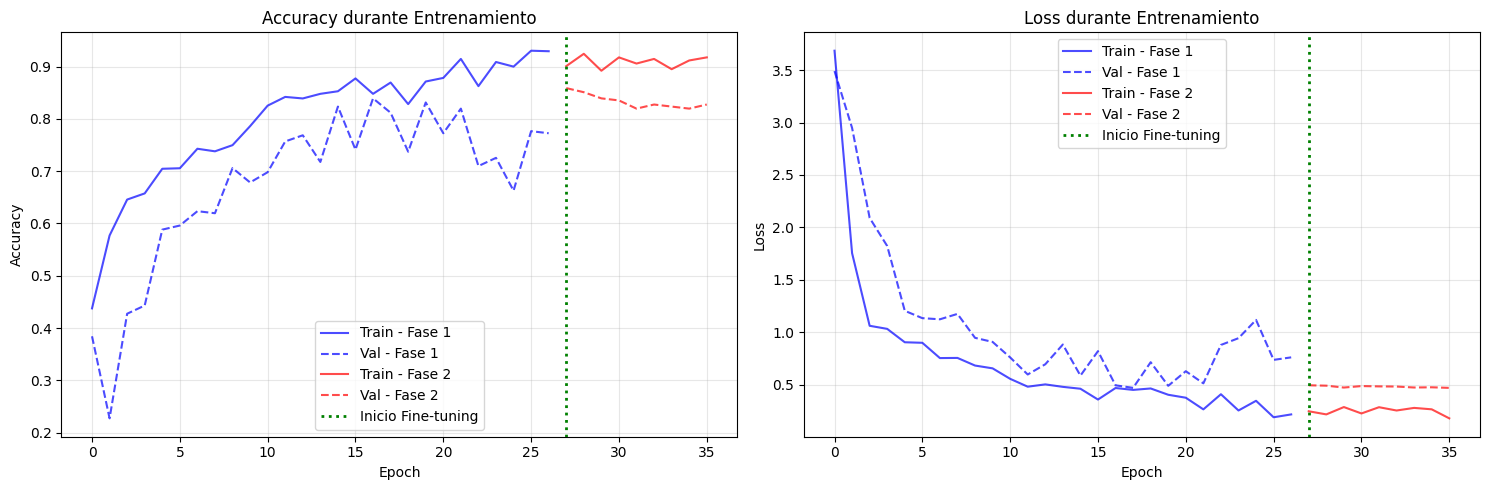

Gráfica guardada: historia_entrenamiento.png


In [80]:
def graficar_historia_entrenamiento(history1, history2):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    axes[0].plot(history1.history['accuracy'], label='Train - Fase 1', color='blue', alpha=0.7)
    axes[0].plot(history1.history['val_accuracy'], label='Val - Fase 1', color='blue', linestyle='--', alpha=0.7)
    
    offset = len(history1.history['accuracy'])
    epochs_fase2 = range(offset, offset + len(history2.history['accuracy']))
    
    axes[0].plot(epochs_fase2, history2.history['accuracy'], label='Train - Fase 2', color='red', alpha=0.7)
    axes[0].plot(epochs_fase2, history2.history['val_accuracy'], label='Val - Fase 2', color='red', linestyle='--', alpha=0.7)
    
    axes[0].axvline(x=offset, color='green', linestyle=':', linewidth=2, label='Inicio Fine-tuning')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Accuracy durante Entrenamiento')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Loss
    axes[1].plot(history1.history['loss'], label='Train - Fase 1', color='blue', alpha=0.7)
    axes[1].plot(history1.history['val_loss'], label='Val - Fase 1', color='blue', linestyle='--', alpha=0.7)
    axes[1].plot(epochs_fase2, history2.history['loss'], label='Train - Fase 2', color='red', alpha=0.7)
    axes[1].plot(epochs_fase2, history2.history['val_loss'], label='Val - Fase 2', color='red', linestyle='--', alpha=0.7)
    
    axes[1].axvline(x=offset, color='green', linestyle=':', linewidth=2, label='Inicio Fine-tuning')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Loss durante Entrenamiento')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('historia_entrenamiento.png', dpi=150, bbox_inches='tight')
    plt.show()

graficar_historia_entrenamiento(history_fase1, history_fase2)
print("Gráfica guardada: historia_entrenamiento.png")

In [81]:
print("RESUMEN DEL EXPERIMENTO")

print("\nBusqueda con Optuna:")
print(f"  Trials realizados: {NUM_TRIALS_BUSQUEDA}")
print(f"  Arquitecturas exploradas: MobileNetV2, EfficientNetB0")
print(f"  Mejor arquitectura: {mejores_params['arquitectura']}")
print(f"  Mejor val accuracy: {mejor_valor:.4f}")

print("\nDivision de Datos:")
print(f"  Train: {len(df_train)} imagenes")
print(f"  Val:   {len(df_val)} imagenes")
print(f"  Test:  {len(df_test)} imagenes")

print("\nEntrenamiento Final:")
print(f"  Fase 1 val acc: {val_acc_fase1:.4f}")
print(f"  Fase 2 val acc: {val_acc_fase2:.4f}")

print("\nRESULTADO FINAL EN TEST (30%):")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Test Loss:     {test_loss:.4f}")

print("\nArchivos Generados:")
print("  mejores_params_busqueda.json")
print("  resultados_trials_busqueda.csv")
print("  mejor_modelo_final.keras")
print("  historia_entrenamiento.png")

RESUMEN DEL EXPERIMENTO

Busqueda con Optuna:
  Trials realizados: 20
  Arquitecturas exploradas: MobileNetV2, EfficientNetB0
  Mejor arquitectura: MobileNetV2
  Mejor val accuracy: 0.8824

Division de Datos:
  Train: 1019 imagenes
  Val:   255 imagenes
  Test:  547 imagenes

Entrenamiento Final:
  Fase 1 val acc: 0.8392
  Fase 2 val acc: 0.8588

RESULTADO FINAL EN TEST (30%):
  Test Accuracy: 0.8793 (87.93%)
  Test Loss:     0.4573

Archivos Generados:
  mejores_params_busqueda.json
  resultados_trials_busqueda.csv
  mejor_modelo_final.keras
  historia_entrenamiento.png
